### Imports

In [1]:
import huggingface_hub
from datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2

import pandas as pd
import os
import gc

from sklearn.base import BaseEstimator, TransformerMixin
from skimage import color, exposure, filters, util, morphology
from skimage import img_as_ubyte, img_as_float
from skimage.filters import rank
from skimage.filters import gaussian
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import umap
from sklearn.manifold import TSNE
from sklearn.svm import SVC

# CUDA/GPU
from cuml.decomposition import PCA as cuPCA
from cuml.manifold import TSNE as cuTSNE
from cuml.preprocessing import minmax_scale as cuml_minmax_scale
from cuml.svm import LinearSVC as cuLinearSVC
from cuml.neighbors import KNeighborsClassifier as cuKNN
from cuml.svm import SVC as cuSVC
from cuml.model_selection import train_test_split
from cuml.manifold import UMAP as cuUMAP
import cudf
import cupy as cp


/home/bimartin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions

In [2]:
def apply_gaussian_filter(image, sigma=6):
    # Create a Gaussian mask that varies only horizontally based on distance from the center
    height, width = image.shape
    y, x = np.ogrid[:height, :width]
    center_x = width / 2

    # Create a Gaussian mask
    # sigma = Standard deviation for the Gaussian function
    mask = np.exp(-((x - center_x)**2) / (2 * sigma**2))

    # Apply the Gaussian mask to the image
    masked_image = image * mask

    # Scale the masked image to 0-255
    masked_image_scaled = (masked_image - np.min(masked_image)) / (np.max(masked_image) - np.min(masked_image)) * 255
    masked_image_scaled = masked_image_scaled.astype(np.uint8)

    return masked_image_scaled, mask

def remove_borders(image, reduce_factor=0.1):
    # Define the border width as 10% of the image size
    border_size = int(32 * reduce_factor)

    blackout_image = image.copy()
    # Set the border regions to black (0)
    # Top border
    blackout_image[:border_size, :] = 0
    # Bottom border
    blackout_image[-border_size:, :] = 0
    # Left border
    blackout_image[:, :border_size] = 0
    # Right border
    blackout_image[:, -border_size:] = 0

    return blackout_image

def find_contours(image):
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    # Create a blank image to draw contours on
    contour_only_image = np.zeros_like(image)
    cv2.drawContours(contour_only_image, contours, -1, 255, 1)  # Draw contours in white (255)
    return contour_only_image

def sharpen_image(image, filter=(5,5)):
    # Sharpen image
    blurred = cv2.GaussianBlur(image, filter, 0)
    return cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

def apply_median_filter(image):
    # Step 2: Reduce the impact of outliers using median filter
    selem = morphology.disk(2)
    return filters.rank.median(img_as_ubyte(image), selem)

def apply_log_filter(image):
    # Create a FunctionTransformer for the log transformation
    log_transformer = FunctionTransformer(np.log1p, validate=True)

    # Apply the log transformation
    transformed_image = log_transformer.fit_transform(image)

    # Rescale the transformed image back to [0, 255]
    transformed_image = (transformed_image / np.max(transformed_image)) * 255
    return transformed_image.astype(np.uint8)

def pipeline(ds,
             labels_ds,
             clahe_clipLimit=2.0,
             clahe_tileGridSize=(3,3),
             sharpen_filter=(5,5),
             gaussian_sigma=6,
             extra_filter=None,
             random_sample_id= None,
             debug=False,
             use_grayscale_only=False,
             use_gaussian_mask=True
             ):
    """ 
    Assumes input dataset are N samples of RGB images, 32x32 (32, 32, 3) shape.
    Input must be a np-array with images only.
    Transforms from RGB (3-channels) to a single grayscale channel
    Applies Gaussian weighting to remove distractions in borders
    Actual digit is centered

    Returns modified dataset
    """
    # Initialize an array to hold the grayscale images
    new_dataset = np.empty((len(ds), 32, 32), dtype=np.uint8)

    if (random_sample_id is None) and debug:
        random_sample_id = random.randint(0, len(ds))
    
    if debug:
        original_random_image = ds[random_sample_id]
        original_random_label = labels_ds[random_sample_id]

    # Step 1: Convert images to grayscale
    gray_images = (color.rgb2gray(ds) * 255).astype(np.uint8)

    if use_grayscale_only:
        return gray_images

    # Iterate per-image
    total_images_processed = 0
    for i in range(0, len(gray_images)):
        
        total_images_processed +=1
        gray_image = gray_images[i]

        # Sharpening
        sharpened_image = sharpen_image(gray_image, sharpen_filter)

        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=clahe_clipLimit, tileGridSize=clahe_tileGridSize)
        clahe_image = clahe.apply(sharpened_image)

        # Median filter
        median_filtered_image = apply_median_filter(clahe_image)

        # Log filter
        log_filtered_image = apply_log_filter(clahe_image)

        image_for_binary = clahe_image
        if (extra_filter=="log"):
            image_for_binary = log_filtered_image
        if (extra_filter=="median"):
            image_for_binary = median_filtered_image

        # Use binary threshold to reduce everything to 2 colors
        _, binary_image = cv2.threshold(image_for_binary, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        #print(f'mean_binary: {np.mean(binary_image)}')

        # Get contours
        contour_image = find_contours(binary_image)

        # Gaussian filter
        masked_image_scaled = binary_image
        if use_gaussian_mask:
            masked_image_scaled, mask = apply_gaussian_filter(binary_image, gaussian_sigma)

        new_dataset[i] = masked_image_scaled

        # Log filter
        # log_filtered_image = apply_log_filter(median_filtered_image)

        if (i == random_sample_id) and debug:
            # List of image data and titles for each row
            images = [
                (original_random_image, gray_image),       # Row 1 images
                (sharpened_image, clahe_image),             # Row 2 images
                (log_filtered_image, median_filtered_image),          # Row 3 images
                (binary_image, contour_image),                     # Row 4 images
                (mask, masked_image_scaled)                # Row 5 image (second image is None)
            ]

            # List of titles for each row
            titles = [
                ("Imagen Original", "Escala de Grises"),
                ("Sharpening", "CLAHE"),
                ("CLAHE + Log", "CLAHE + Median"),
                ("Binary Dynamic Threshold", "Contornos"),
                ("Máscara Gaussiana", "Imagen enmascarada")  # No second title for this row
            ]

            # Loop over the rows to create and save individual images for each row
            for i, (row_images, row_titles) in enumerate(zip(images, titles)):
                # Create a figure for the current row
                fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 images per row

                primer_paso = i*2
                segundo_paso = (i*2)+1
                #fig.suptitle(f'Pasos {primer_paso} y {segundo_paso}', fontsize=16)

                # Plot the first image in the row
                axes[0].imshow(row_images[0], cmap='gray')
                axes[0].set_title(row_titles[0])
                axes[0].axis('off')

                # If there is a second image, plot it
                if row_images[1] is not None:
                    axes[1].imshow(row_images[1], cmap='gray')
                    axes[1].set_title(row_titles[1])
                    axes[1].axis('off')
                else:
                    axes[1].axis('off')  # Hide the second axis if no second image

                # Save the image for the current row
                plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust spacing if necessary

                plt.savefig(f'row_{i+1}_images.png', dpi=300, bbox_inches='tight')  # Save each row's image
                #plt.close()  # Close the figure to free up memory

    return new_dataset

### Preprocessing transformer class

In [3]:
class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 clahe_clipLimit=2.0,
                 clahe_tileGridSize=(3, 3),
                 sharpen_filter=(5, 5), 
                 gaussian_sigma=6,
                 extra_filter=None,
                 random_sample_id=None,
                 debug=False,
                 use_gpu=False,
                 use_grayscale_only=False,
                 use_gaussian_mask=True):
        # Store preprocessing parameters
        self.clahe_clipLimit = clahe_clipLimit
        self.clahe_tileGridSize = clahe_tileGridSize
        self.sharpen_filter = sharpen_filter
        self.gaussian_sigma = gaussian_sigma
        self.extra_filter = extra_filter
        self.random_sample_id = random_sample_id
        self.debug = debug
        self.use_gpu = use_gpu
        self.use_grayscale_only = use_grayscale_only
        self.use_gaussian_mask = use_gaussian_mask

    def fit(self, X, y=None):
        # This method can stay empty since we don't need fitting for preprocessing
        return self

    def transform(self, X, y=None):

        # CPU-only processed data
        processed_data = pipeline(
            ds=X, 
            labels_ds=y, 
            clahe_clipLimit=self.clahe_clipLimit, 
            clahe_tileGridSize=self.clahe_tileGridSize, 
            sharpen_filter=self.sharpen_filter, 
            gaussian_sigma=self.gaussian_sigma, 
            extra_filter=self.extra_filter, 
            random_sample_id=self.random_sample_id,
            debug=self.debug,
            use_grayscale_only = self.use_grayscale_only,
            use_gaussian_mask = self.use_gaussian_mask
        )

        # Flatten data
        processed_data = processed_data.reshape(processed_data.shape[0], -1)
        processed_data = processed_data/255

        # Convert data to GPU if needed
        if self.use_gpu:
            # Scale the data on GPU
            #processed_data = cuml_minmax_scale(processed_data, feature_range=(0, 1))
    
            # Convert to cudf DataFrame on GPU
            processed_data = cudf.DataFrame.from_pandas(pd.DataFrame(processed_data)).to_cupy()
        return processed_data

### Import Dataset

In [4]:
# Import cropped-digits dataset
dataset_cropped_digits_raw = load_dataset("ufldl-stanford/svhn",
                                          "cropped_digits",
                                          cache_dir='../data/svhn/')

# Get dataset subsets
ds_train = dataset_cropped_digits_raw["train"]
ds_test =  dataset_cropped_digits_raw["test"]
#ds_extra = dataset_cropped_digits_raw["extra"]

ds_train_images = np.array(ds_train["image"])
ds_test_images =  np.array(ds_test["image"])
#ds_extra_images = np.array(ds_extra["image"])

In [5]:
Y_train = np.array(ds_train["label"])
Y_test =  np.array(ds_test["label"])
#Y_extra = np.array(ds_extra["label"])

### Preprocess data demo

array([0.20392157, 0.24705882, 0.29803922, ..., 0.        , 0.        ,
       0.        ])

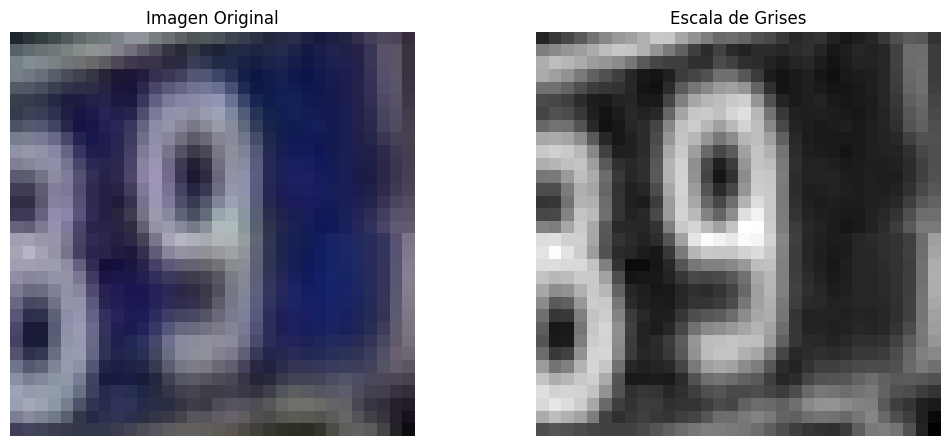

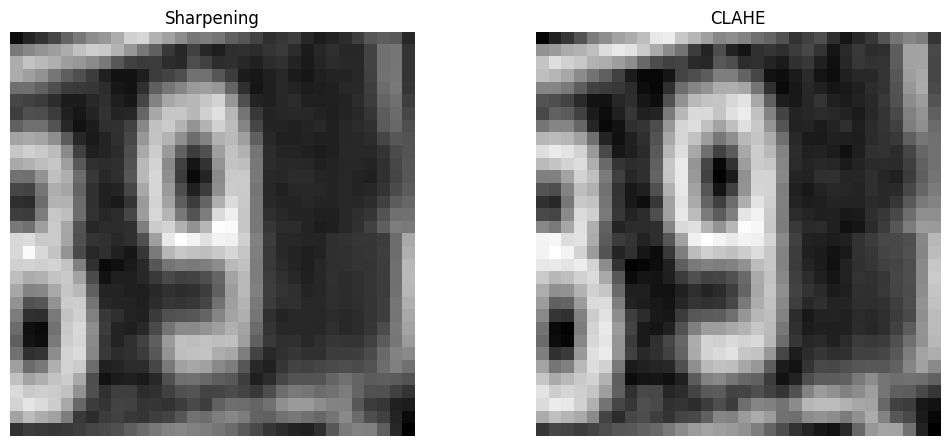

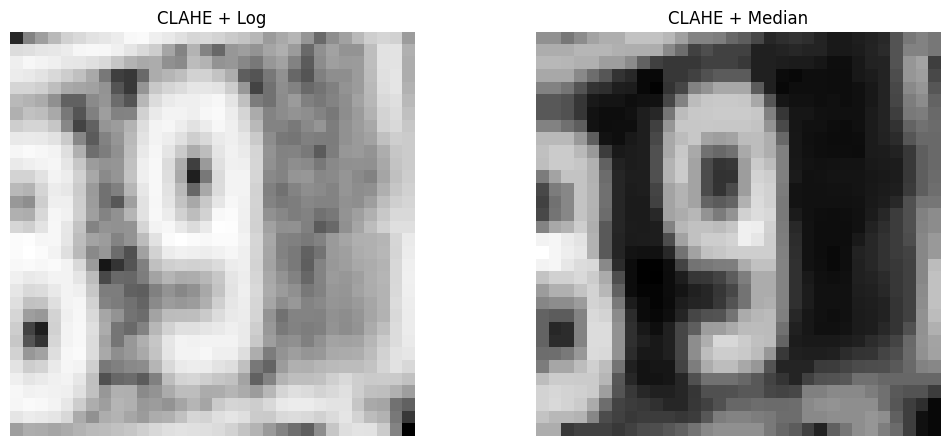

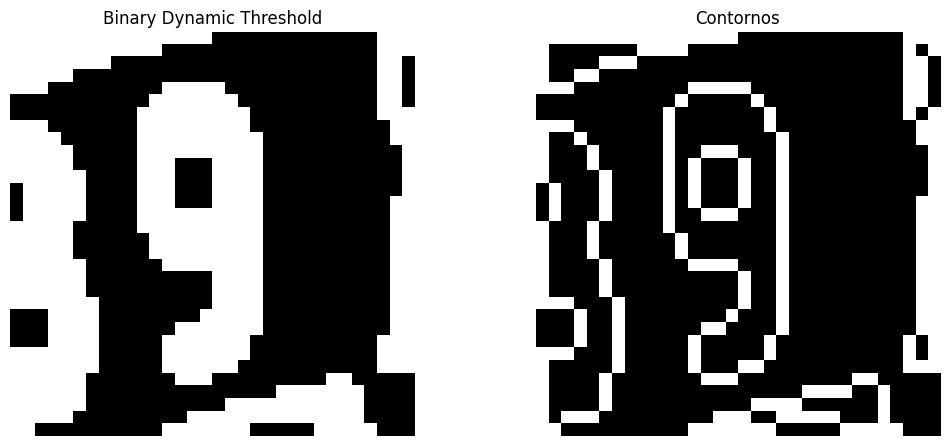

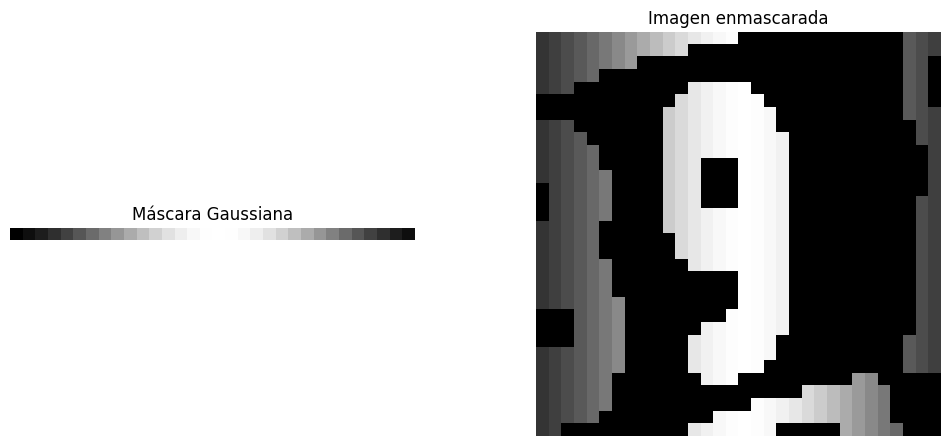

In [6]:
transformer = PreprocessingTransformer(gaussian_sigma=9,
                                       extra_filter='median',
                                       debug=True,
                                       random_sample_id=0)

X_pca_train = transformer.transform(X=np.expand_dims(ds_train_images[50],
                                    axis=0),
                                    y=Y_train)

X_pca_train[0]

#X_train = transformer.transform(ds_train_images)
#X_test  = transformer.transform(ds_test_images)

### Dimensionality reduction

In [10]:
# Pre-process data first
transfromer_demo = PreprocessingTransformer(gaussian_sigma=6,
                                            extra_filter='median',
                                            use_gpu=True)
X_for_dimensionality_reduction_demo = transfromer_demo.transform(ds_train_images)

In [11]:
cmap = 'RdYlBu'

### Plot correlation matrix

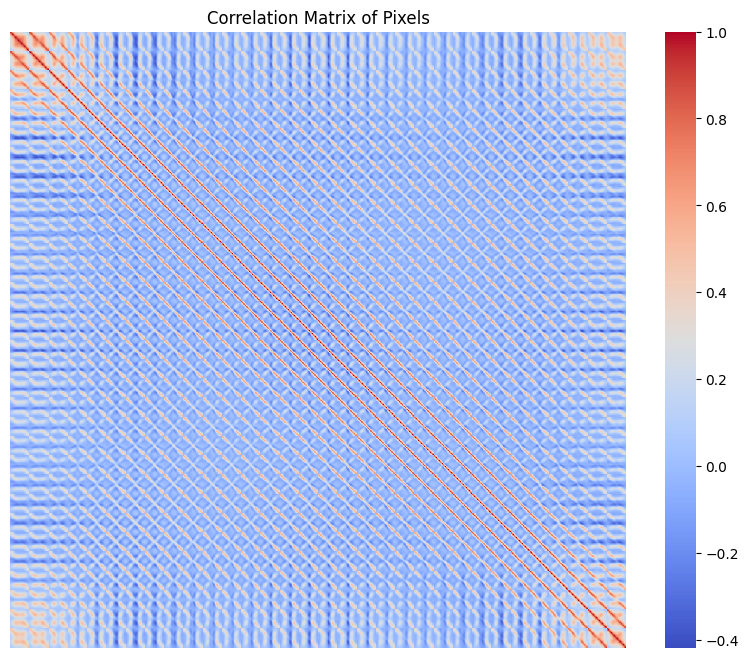

In [14]:
import seaborn as sns

corr_matrix = np.corrcoef(X_for_dimensionality_reduction_demo.get(), rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, xticklabels=False, yticklabels=False)
plt.title('Correlation Matrix of Pixels')
plt.show()

#### PCA: 2D and 3D

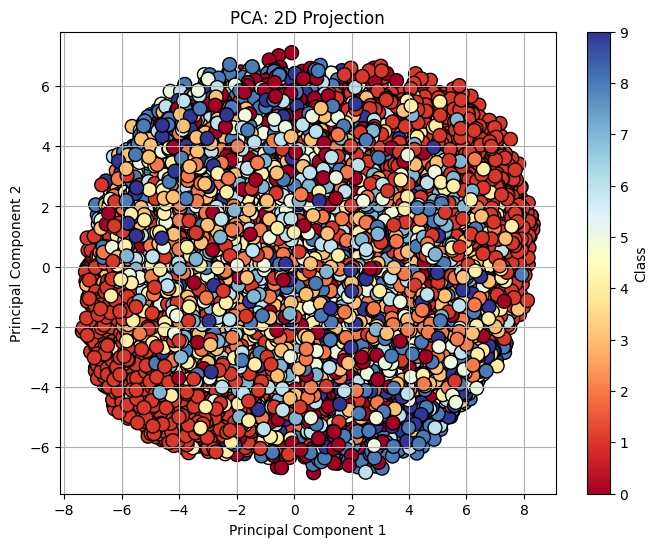

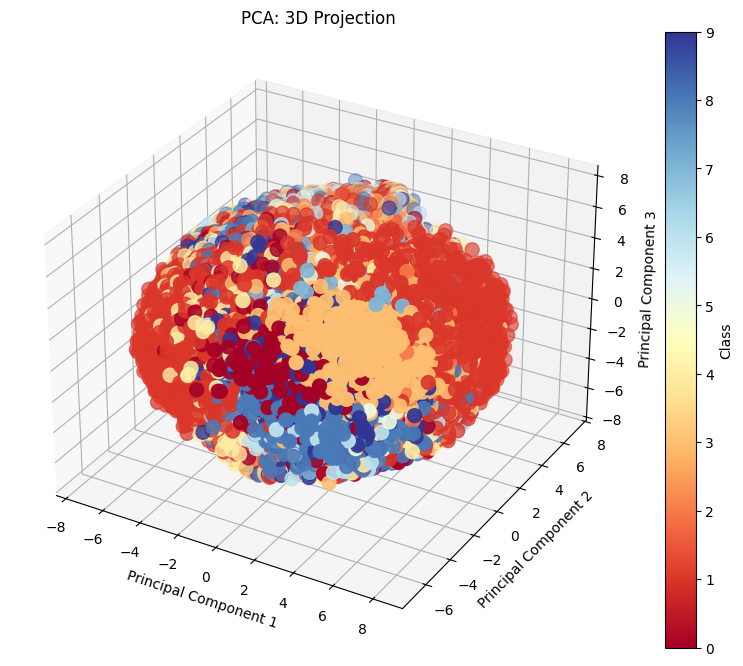

In [15]:
# PCA to 2D
pca_2d = cuPCA(n_components=2)
X_2d = pca_2d.fit_transform(X_for_dimensionality_reduction_demo).get()

# PCA to 3D
pca_3d = cuPCA(n_components=3)
X_3d = pca_3d.fit_transform(X_for_dimensionality_reduction_demo).get()

# Plotting the 2D PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=Y_train, cmap=cmap, edgecolor='k', s=100)
plt.title('PCA: 2D Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Class')
plt.grid(True)
plt.savefig('pca_2d_projection.png', dpi=300, bbox_inches='tight')
plt.show()

# Plotting the 3D PCA results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=Y_train, cmap=cmap, s=100)
ax.set_title('PCA: 3D Projection')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
fig.colorbar(scatter, ax=ax, label='Class')
plt.savefig('pca_3d_projection.png', dpi=300, bbox_inches='tight')
plt.show()

#### UMAP: 2d and 3d

In [16]:
# UMAP to 2D
umap_2d = cuUMAP(n_components=2, random_state=42)
X_umap_2d = umap_2d.fit_transform(X_for_dimensionality_reduction_demo).get()

# UMAP to 3D
umap_3d = cuUMAP(n_components=3, random_state=42)
X_umap_3d = umap_3d.fit_transform(X_for_dimensionality_reduction_demo).get()

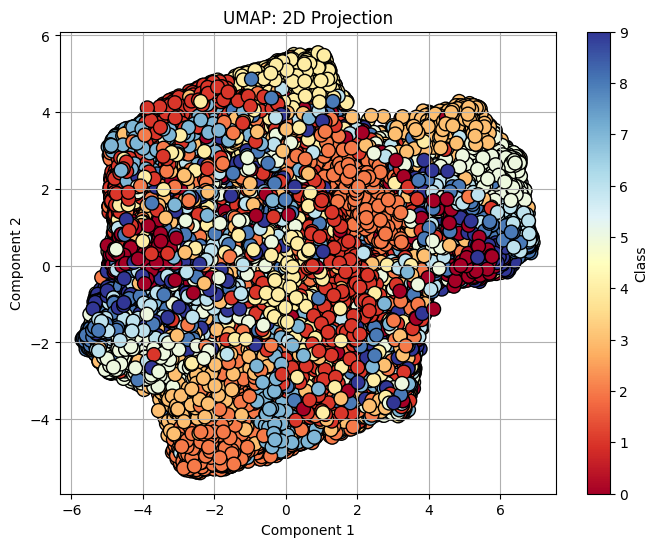

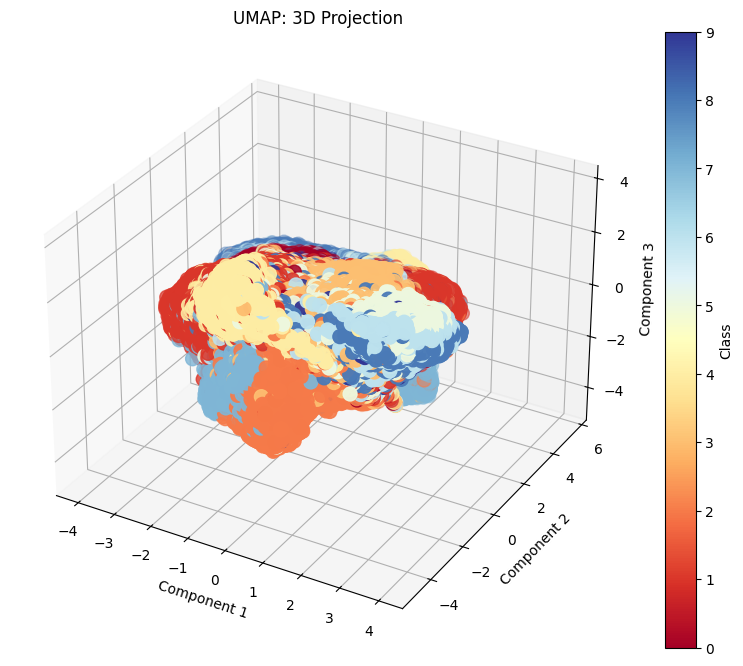

In [17]:
# Plotting the UMAP 2D results
plt.figure(figsize=(8, 6))
plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=Y_train, cmap=cmap, edgecolor='k', s=100)
plt.title('UMAP: 2D Projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Class')
plt.grid(True)
plt.savefig('umap_2d_projection.png', dpi=300, bbox_inches='tight')
plt.show()

# Plotting the UMAP 3D results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2], c=Y_train, cmap=cmap, s=100)
ax.set_title('UMAP: 3D Projection')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
fig.colorbar(scatter, ax=ax, label='Class')
plt.savefig('umap_3d_projection.png', dpi=300, bbox_inches='tight')
plt.show()

#### tSNE: 2D and 3D

In [18]:
if False:
    # t-SNE to 2D
    tsne_2d = cuTSNE(n_components=2, random_state=42)
    X_tsne_2d = tsne_2d.fit_transform(X_for_dimensionality_reduction_demo)

    # t-SNE to 3D
    tsne_3d = cuTSNE(n_components=3, random_state=42)
    X_tsne_3d = tsne_3d.fit_transform(X_for_dimensionality_reduction_demo)

In [19]:
if False:
    # Plotting the t-SNE 2D results
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=Y_train, cmap=cmap, edgecolor='k', s=100)
    plt.title('t-SNE: 2D Projection')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(label='Class')
    plt.grid(True)
    plt.savefig('tsne_2d_projection.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plotting the t-SNE 3D results
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=Y_train, cmap=cmap, s=100)
    ax.set_title('t-SNE: 3D Projection')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    fig.colorbar(scatter, ax=ax, label='Class')
    plt.savefig('tsne_3d_projection.png', dpi=300, bbox_inches='tight')
    plt.show()

### Use SMOTE for skewed dataset

In [20]:
# Get dataset subsets

X_train = ds_train_images

# Step 1: Flatten images (from 32x32x3 to 3072-dimensional vectors)
X_train = ds_train_images.reshape(ds_train_images.shape[0], -1)  # Shape (num_samples, 32*32*3)

# Step 2: Normalize images to [0, 1]
X_train = X_train / 255.0

# Step 3: Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

# Step 4: Optionally, reshape back to original image dimensions (32x32x3)
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)


### Test with our best parameters/model

PCA_AND_SVM | Best parameters: {'preprocessing__use_gaussian_mask': True, 'preprocessing__gaussian_sigma': 6, 'preprocessing__extra_filter': 'median', 'pca__n_components': 57, 'svm__C': 1, 'svm__kernel': 'poly', 'svm__degree': 6}

PCA_AND_SVM | Best score: 0.7990934252738953

In [21]:
validation_pipeline = Pipeline(
steps=[
    ('preprocessing', PreprocessingTransformer(use_gaussian_mask=True,
                                               use_grayscale_only=False,
                                               gaussian_sigma=9,
                                               extra_filter='median',
                                               use_gpu=True)),
    ('pca', cuPCA(
        n_components=57,
        random_state=42)),
    ('svm', cuSVC(
        C=1,
        kernel='poly',
        degree=6))
])

validation_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing',
                 PreprocessingTransformer(extra_filter='median',
                                          gaussian_sigma=9, use_gpu=True)),
                ('pca', PCA()), ('svm', SVC())])

### Do a simple test of our prediction with 10 items

In [22]:
dbg_idx = 42
extra = 10
new_pred = validation_pipeline.predict(X_train[dbg_idx:dbg_idx+extra])
print(f'pred: {new_pred}\ntruth:{Y_train[dbg_idx:(dbg_idx+extra)]}')

pred: [2 2 5 1 5 4 7 8 9 6]
truth:[2 2 5 1 5 4 7 8 9 6]


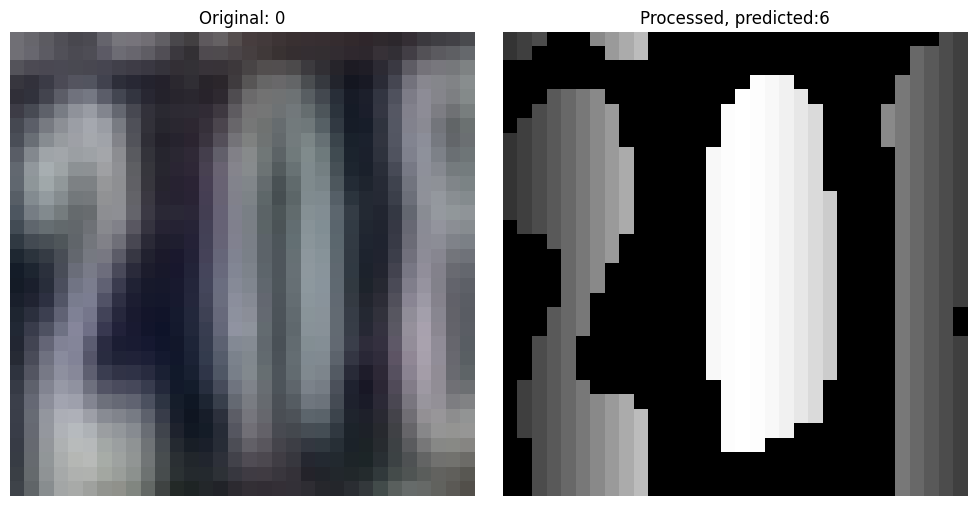

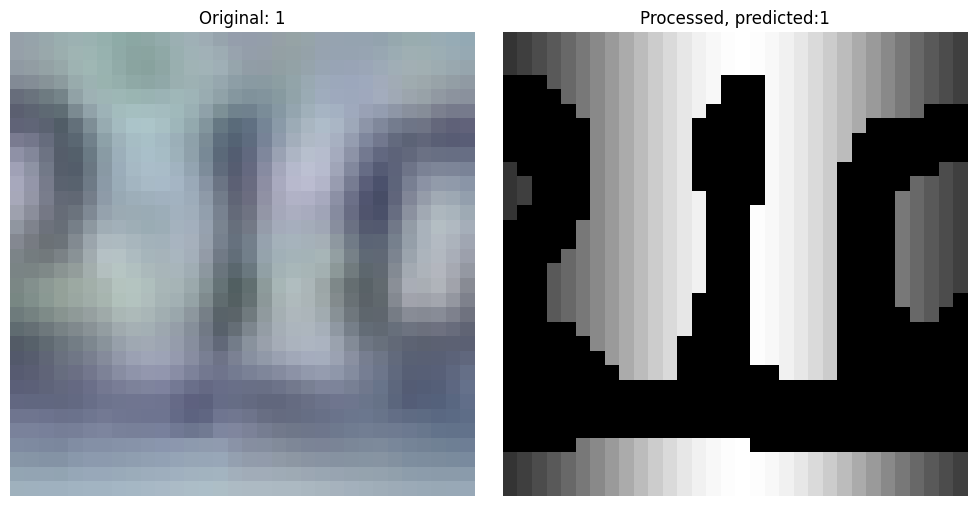

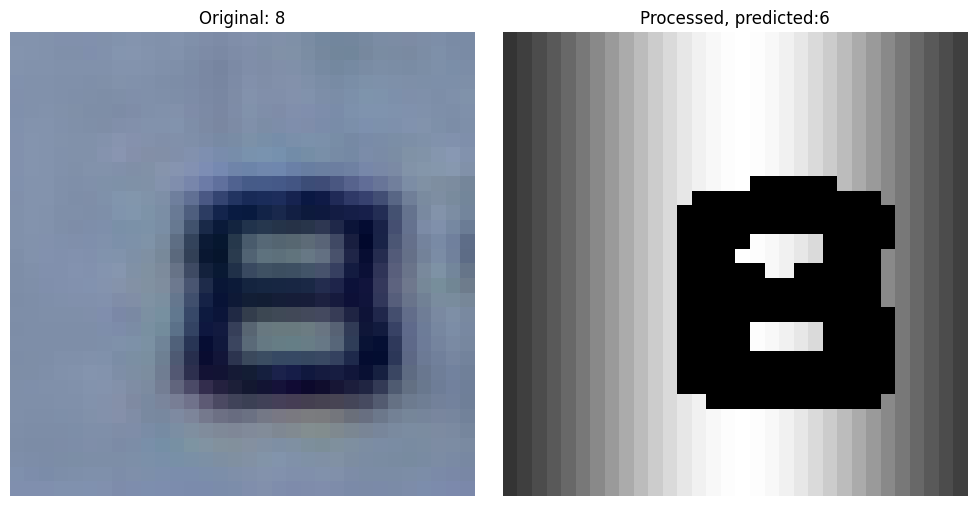

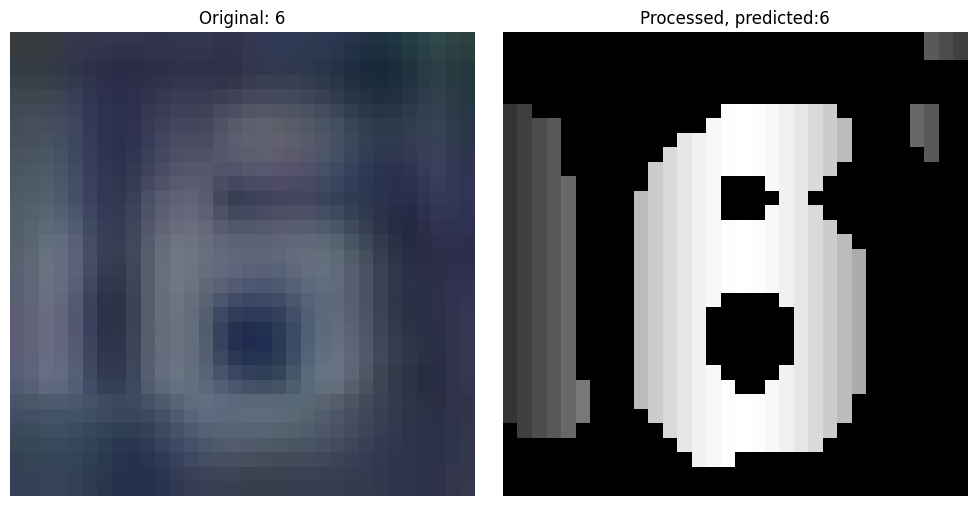

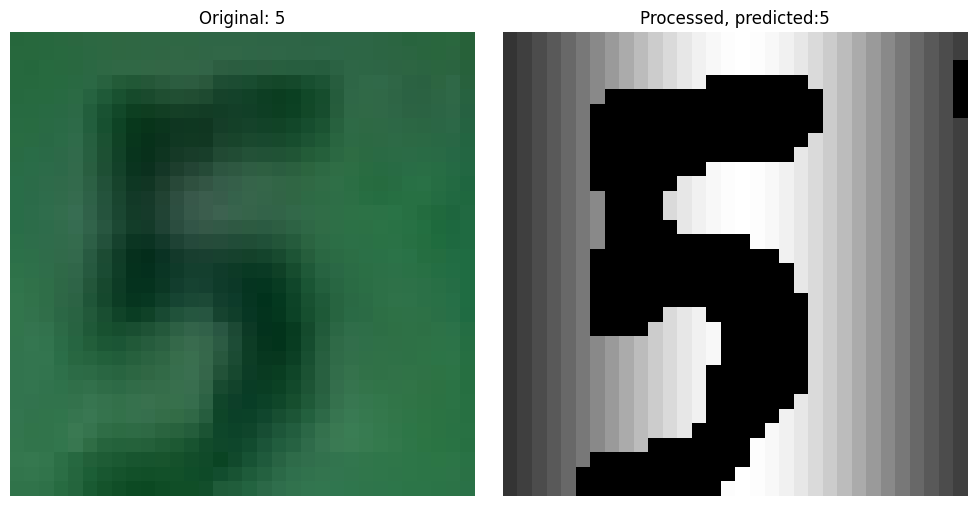

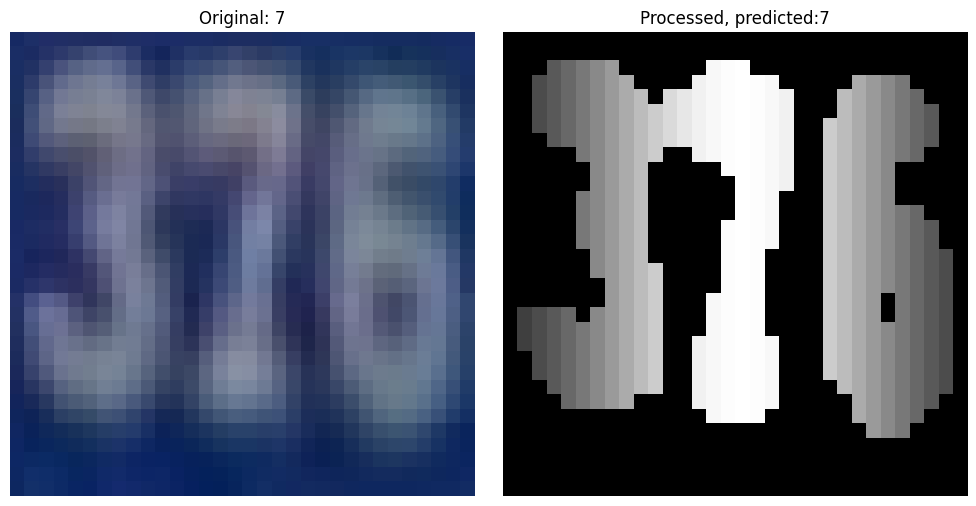

In [30]:
# Plot the image

## 55 and 42, 888

for index_test in [888, 2, 55, 42, 0, 111]:
    test_image = ds_test_images[index_test]
    test_image_for_pipe = np.expand_dims(test_image, axis=0)

    processed_image = validation_pipeline.named_steps['preprocessing'].transform(test_image_for_pipe).get()[0].reshape(32, 32)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    # Plot the first image
    actual = ds_test['label'][index_test]
    axes[0].imshow(test_image)
    axes[0].set_title(f"Original: {actual}")
    axes[0].axis('off')  # Turn off axis labels

    # Plot the second image
    pred = validation_pipeline.predict(test_image_for_pipe)[0]
    axes[1].imshow(processed_image, cmap='gray')  # Use cmap='gray' for grayscale images
    axes[1].set_title(f"Processed, predicted:{pred}")
    axes[1].axis('off')  # Turn off axis labels

    # Show the plot
    plt.savefig(f'pred_example_actual_{actual}_pred_{pred}.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

### Test Score

In [24]:
Y_test_predict = validation_pipeline.predict(ds_test_images)
accuracy_score(Y_test, Y_test_predict.get())

0.8307467732022127

### Training score

In [25]:
Y_train_predict = validation_pipeline.predict(X_train)
accuracy_score(Y_train, Y_train_predict.get())

0.9838684077627877

#### Extra dataset score

In [26]:
#Y_extra_predict = validation_pipeline.predict(ds_extra_images)
#accuracy_score(Y_extra, Y_extra_predict)

### Plot confusion matrix

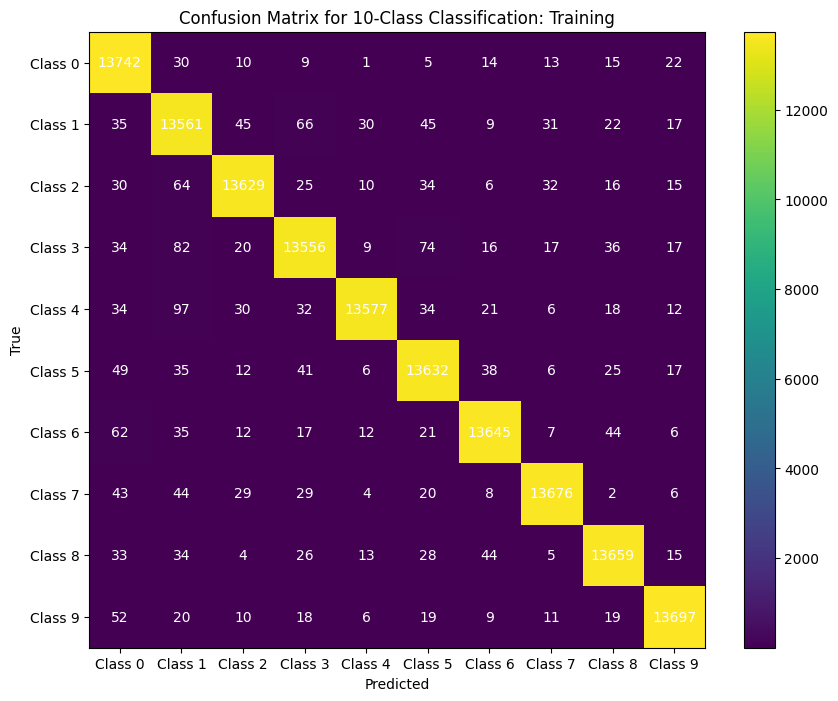

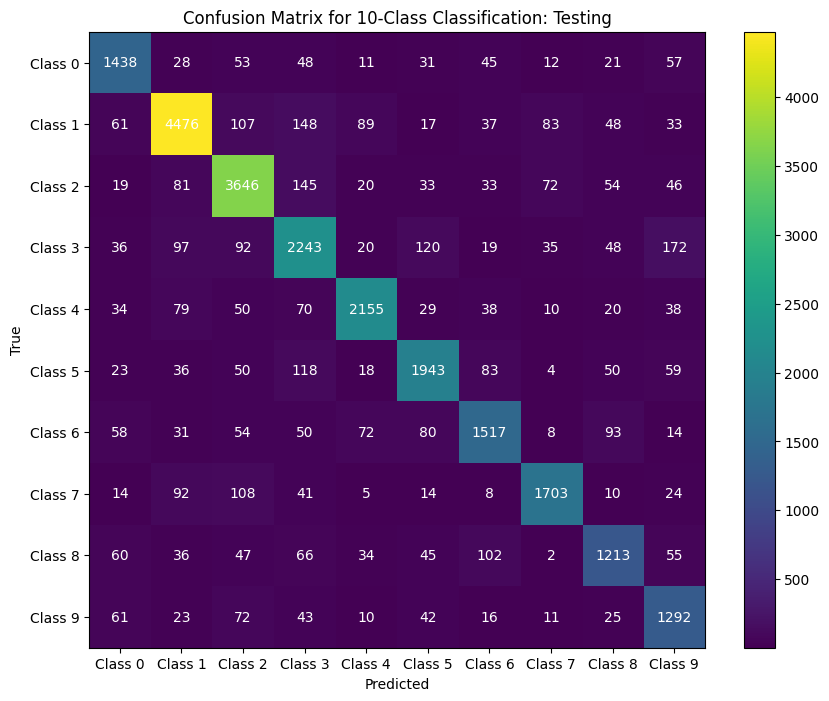

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming Y_test and Y_test_predict are defined
# Example:
# Y_test = [true labels]
# Y_test_predict = [predicted labels]

confussion_array = [
    ['Training', Y_train_predict.get(), Y_train],
    ['Testing', Y_test_predict.get(), Y_test]
]

for prediction in confussion_array:
    confm = confusion_matrix(prediction[2], prediction[1])

    # Create a figure
    plt.figure(figsize=(10, 8))

    # Plot the confusion matrix as an image (heatmap)
    plt.imshow(confm, interpolation='nearest', cmap='viridis')

    # Add a colorbar
    plt.colorbar()

    # Add annotations (the counts on each cell)
    for i in range(confm.shape[0]):
        for j in range(confm.shape[1]):
            plt.text(j, i, f'{confm[i, j]}', ha='center', va='center', color='white')

    # Add labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for 10-Class Classification: {prediction[0]}')

    # Set ticks for the x and y axes
    plt.xticks(np.arange(10), [f'Class {i}' for i in range(10)])
    plt.yticks(np.arange(10), [f'Class {i}' for i in range(10)])

    # Show the plot
    plt.savefig(f'confusion_matrix_{prediction[0]}_postSMOTE.png', dpi=300, bbox_inches='tight')
    plt.show()
